In [3]:
!pip install torchvision

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.6 MB 1.5 MB/s eta 0:00:01
   -------------------- ------------------- 0.8/1.6 MB 1.9 MB/s eta 0:00:01
   -------------------------- ------------- 1.0/1.6 MB 1.5 MB/s eta 0:00:01
   --------------------------------- ------ 1.3/1.6 MB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 1.4 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# --- Set device to CPU ---
device = torch.device("cpu")

# --- Hyperparameters ---
img_size = 64
batch_size = 32
latent_dim = 100
num_epochs = 50
lr = 0.0002
beta1 = 0.5

# --- Dataset Path ---
data_path = "C:\\Users\\prata\\Downloads\\archive\\chest_xray\\train"

# --- Data Preprocessing ---
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((img_size, img_size)),  
    transforms.ToTensor(),  
    transforms.Normalize([0.5], [0.5])  
])

# --- Load Dataset ---
dataset = datasets.ImageFolder(root=data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# --- Generator ---
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, img_size * img_size),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, img_size, img_size)
        return img

# --- Discriminator ---
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_size * img_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# --- Initialize Models ---
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# --- Loss & Optimizers ---
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# --- Training Loop ---
for epoch in range(num_epochs):
    for i, (real_imgs, _) in enumerate(dataloader):

        # Move images to CPU
        real_imgs = real_imgs.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(z)
        real_loss = criterion(discriminator(real_imgs), torch.ones(real_imgs.size(0), 1).to(device))
        fake_loss = criterion(discriminator(fake_imgs.detach()), torch.zeros(batch_size, 1).to(device))
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = criterion(discriminator(fake_imgs), torch.ones(batch_size, 1).to(device))
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

print("Training Complete!")


Epoch [1/50] | D Loss: 0.2448 | G Loss: 1.4182
Epoch [2/50] | D Loss: 0.5556 | G Loss: 0.3716
Epoch [3/50] | D Loss: 0.4393 | G Loss: 3.1668
Epoch [4/50] | D Loss: 0.5517 | G Loss: 2.3873
Epoch [5/50] | D Loss: 0.4899 | G Loss: 1.3798
Epoch [6/50] | D Loss: 0.3627 | G Loss: 1.7680
Epoch [7/50] | D Loss: 0.4282 | G Loss: 1.4395
Epoch [8/50] | D Loss: 0.4937 | G Loss: 2.0217
Epoch [9/50] | D Loss: 0.4315 | G Loss: 1.4873
Epoch [10/50] | D Loss: 0.4443 | G Loss: 1.5208
Epoch [11/50] | D Loss: 0.7030 | G Loss: 2.1650
Epoch [12/50] | D Loss: 0.3685 | G Loss: 1.3973
Epoch [13/50] | D Loss: 0.5162 | G Loss: 1.3905
Epoch [14/50] | D Loss: 0.4502 | G Loss: 1.4346
Epoch [15/50] | D Loss: 0.4684 | G Loss: 1.8318
Epoch [16/50] | D Loss: 0.5866 | G Loss: 1.4363
Epoch [17/50] | D Loss: 0.6047 | G Loss: 1.7019
Epoch [18/50] | D Loss: 0.7720 | G Loss: 0.9038
Epoch [19/50] | D Loss: 0.6206 | G Loss: 1.6202
Epoch [20/50] | D Loss: 0.6119 | G Loss: 1.1493
Epoch [21/50] | D Loss: 0.5037 | G Loss: 1.5117
E

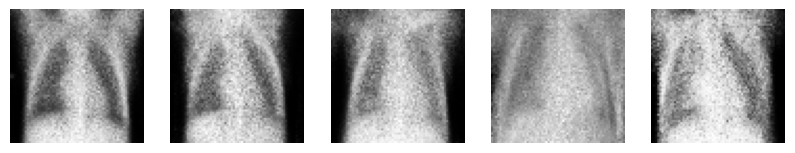

In [5]:

import matplotlib.pyplot as plt
import numpy as np

# Generate a batch of images
num_samples = 5  # Change this to generate more images
z = torch.randn(num_samples, latent_dim).to(device)
fake_imgs = generator(z).detach().cpu().numpy()

# Plot the generated images
fig, axes = plt.subplots(1, num_samples, figsize=(10, 2))
for i in range(num_samples):
    img = np.squeeze(fake_imgs[i])  # Remove extra dimension
    axes[i].imshow(img, cmap="gray")
    axes[i].axis("off")

plt.show()


In [7]:
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")

In [9]:
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(real_img, fake_img):
    real_img = np.squeeze(real_img)  # Remove extra dimension
    fake_img = np.squeeze(fake_img)
    return ssim(real_img, fake_img, data_range=2)  # Since images are normalized

# Pick a real image from dataset
real_img, _ = dataset[0]
real_img = real_img.numpy()

# Generate an image
z = torch.randn(1, latent_dim).to(device)
fake_img = generator(z).detach().cpu().numpy()

# Calculate SSIM
score = calculate_ssim(real_img, fake_img)
print(f"SSIM Score: {score:.4f}")

SSIM Score: 0.1051


In [11]:
generator.load_state_dict(torch.load("generator.pth", map_location=torch.device("cpu")))
discriminator.load_state_dict(torch.load("discriminator.pth", map_location=torch.device("cpu")))
generator.eval()  # Set to evaluation mode
discriminator.eval()

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=4096, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=256, out_features=1, bias=True)
    (7): Sigmoid()
  )
)